## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [30]:

from torch.nn import Linear,Embedding,Sequential,ReLU,Dropout,BatchNorm1d,CrossEntropyLoss,Sigmoid
from torch.optim import Adam,RMSprop
from torch.autograd import Variable
import torch.nn.functional as F
import string
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
from random import sample
from torch import nn
import torch
torch.cuda.is_available()

np.random.seed(0)

In [3]:
BATCH_SIZE=2048

In [4]:
!nvidia-smi

Thu May 16 18:15:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [5]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-05-16 18:15:33--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.01s   

2024-05-16 18:15:33 (7.98 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text[0] = ' ' + text[0]
out = ' '.join(text).lower()
list_text = out.split('\n')
out = out.replace('\n', '')
# out = out.replace('  ', ' ')
# out = ' ' + out
text = out

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [8]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()

# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [12]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [13]:
# dict <index>:<char>
# Your great code here



id_to_token = {idx: token for idx, token in enumerate(tokens)}

token_to_id = {token: idx for idx, token in enumerate(tokens)}

num_tokens = len(tokens)
# dict <char>:<index>
# Your great code here

In [14]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [15]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=15, rnn_num_units=1024):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        h_next = F.tanh(h_next)

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits
        # return h_next, F.log_softmax(logits, dim=-1)

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [18]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size).to(device)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)

In [21]:
char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
history = []
loss_func = nn.CrossEntropyLoss()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [22]:
MAX_LENGTH = max(map(len, list_text))
MAX_LENGTH

63

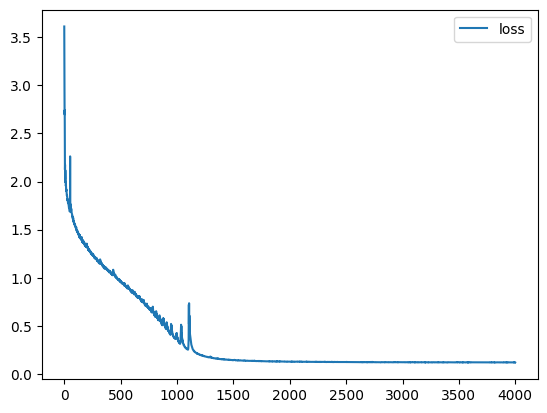

In [23]:
# Your plot code here
for i in range(4000):
    batch_ix = to_matrix(sample(list_text, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[ :,1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    loss = loss_func(
    predictions_logp.reshape(-1, num_tokens),
    actual_next_tokens.reshape(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    # visualizing training process
    history.append(loss.cpu().data.numpy())
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [24]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i].to(device), hid_state)

    #start generating
    for _ in range(MAX_LENGTH):
        hid_state, logp_next = char_rnn(x_sequence[:, -1].to(device), hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).cpu().data.numpy()[0]
        # sample next token and push it back into x_sequence
        # output_dist = logp_next.data.view(-1).div(temperature).exp()
        # top_i = torch.multinomial(output_dist, 1)[0]

        next_ix = np.random.choice(len(tokens), p=p_next)

        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(next_ix)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        # print(x_sequence.shape)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [25]:
first_word = 'knight with a horse '
for _ in range(10):
    answer = generate_sample(char_rnn,seed_phrase=first_word,temperature=0.2)
    first_word = random.choice(answer.strip().split(' '))
    print(answer)


knight with a horse crow'd, still be the vear hous wiill; of preaser,              
of couthin me thou mayst cault us yout with stope that good ounla
ushaiding him birts,                                             
ushaiding h morths would gaze thee,                                     
wouldste;                                                           
wouldste;                                                               
wouldste;                                                               
wouldste;                                                               
wouldste;                                                               
wouldste;                                                               


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [26]:
class LSTMCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    def __init__(self, num_tokens=len(tokens), embedding_size=15, lstm_num_units=1024):
        super(self.__class__,self).__init__()
        self.num_units = lstm_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.fc1 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)
        self.fc2 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)
        self.fc3 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)
        self.fc4 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)

        self.lstm_to_logits = nn.Linear(lstm_num_units, num_tokens)
    def forward(self, x, h_prev,c_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous lstm hidden states, variable containing matrix [batch, lstm_num_units] of float32
        """
        # x=torch.tensor(x, dtype=torch.int64)
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        f=F.sigmoid(self.fc1(x_and_h))
        i=F.sigmoid(self.fc2(x_and_h))
        c=F.tanh(self.fc3(x_and_h))
        o=F.sigmoid(self.fc4(x_and_h))
        c_next = c_prev*f+i*c
        h_next = F.tanh(c_next)*o
        logits = self.lstm_to_logits(h_next)

        assert h_next.size() == h_prev.size()
        assert c_next.size() == c_prev.size()

        #compute logits for next character probs
        logits = self.lstm_to_logits(h_next)

        return h_next,c_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        """ return lstm state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32)),Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32))

In [27]:
def lstm_loop(lstm, batch_index):
    """
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state,cell_state = lstm.initial_state(batch_size)
    hid_state=hid_state.to(device)
    cell_state=cell_state.to(device)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, cell_state, logp_next = lstm(x_t, hid_state, cell_state)
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)

In [28]:
char_lstm = LSTMCell().to(device)
opt = torch.optim.Adam(char_lstm.parameters())
history = []

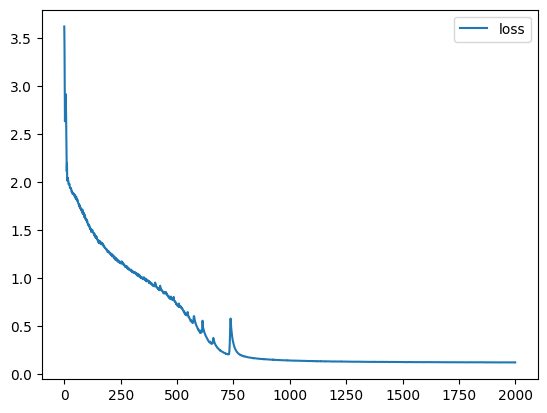

In [29]:
for i in range(2000):
    batch_ix = to_matrix(sample(list_text, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq = lstm_loop(char_lstm, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    # visualizing training process
    history.append(loss.cpu().data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
def generate_sample_lstm(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.3):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state, cell_state = char_rnn.initial_state(batch_size=1)
    hid_state=hid_state.to(device)
    cell_state=cell_state.to(device)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state,cell_state, _ = char_rnn(x_sequence[:, i].to(device), hid_state, cell_state)

    #start generating
    for _ in range(max_length):
        hid_state, cell_state,logp_next = char_rnn(x_sequence[:, -1].to(device), hid_state, cell_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).cpu().data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
# Text generation with different temperature values here
# def generation(model, phrase):

#   for _ in range(10):
#       answer = generate_sample(model, seed_phrase=phrase,temperature=0.2)
#       phrase = random.choice(answer.strip().split(' '))
#       print(answer)

# first_word = 'knight with a horse '
# generation(char_lstm, first_word)

first_word = 'knight with a horse '
for _ in range(10):
    answer = generate_sample_lstm(char_lstm,seed_phrase=first_word,temperature=0.2)
    print(answer)

knight with a horse with thine                                 
knight with a horse wird                                       
knight with a horse with thine                                 
knight with a horse with thine                                 
knight with a horse wird                                       
knight with a horse wird                                       
knight with a horse with thine                                 
knight with a horse wird                                       
knight with a horse with thine                                 
knight with a horse wird                                       


In [ ]:
first_word = 'knight with a horse '
for _ in range(10):
    answer = generate_sample_lstm(char_lstm,seed_phrase=first_word,temperature=0.1)
    print(answer)

In [ ]:
first_word = 'knight with a horse '
for _ in range(10):
    answer = generate_sample_lstm(char_lstm,seed_phrase=first_word,temperature=0.5)
    print(answer)

In [ ]:
first_word = 'knight with a horse '
for _ in range(10):
    answer = generate_sample_lstm(char_lstm,seed_phrase=first_word,temperature=1)
    print(answer)

In [ ]:
first_word = 'knight with a horse '
for _ in range(10):
    answer = generate_sample_lstm(char_lstm,seed_phrase=first_word,temperature=2)
    print(answer)

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

torch.save(char_lstm.state_dict(), 'char_lstm.pt')
torch.save(char_rnn.state_dict(), 'char_rnn.pt')


device = torch.device('cpu')
char_lstm.load_state_dict(torch.load('char_lstm.pt', map_location=device))

device = torch.device('cpu')
char_rnn.load_state_dict(torch.load('char_rnn.pt', map_location=device))

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)